First analysis of the Hainich data using GPFA for filling the gaps

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from gpfa_imputation.imputation import *
from gpfa_imputation.data_preparation import *

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from pyprojroot import here
import matplotlib.pyplot as plt

In [55]:
torch.manual_seed(27);
np.random.seed(27);

## Load Data

take the first 200 rows from the Hainich dataset

In [64]:
hai_path = Path("FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4.csv")
hai_raw = pd.read_csv(here("data") / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1], nrows=200)

In [65]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    #"PA": "PA"
}

units = {
    'TA': '°C',
    'SW_IN': 'W m-2',
    'LW_IN': 'W m-2',
    'VPD': 'hPa'
}

hai = (hai_raw
       .rename(columns=meteo_vars)
       .set_index("TIMESTAMP_END")
       .loc[:, meteo_vars.values()])
hai

,TA,SW_IN,LW_IN,VPD
TIMESTAMP_END,,,,
2000-01-01 00:30:00,-0.60,0.0,302.475,0.222
2000-01-01 01:00:00,-0.65,0.0,302.475,0.122
2000-01-01 01:30:00,-0.58,0.0,301.677,0.090
2000-01-01 02:00:00,-0.51,0.0,301.677,0.110
2000-01-01 02:30:00,-0.49,0.0,301.677,0.102
...,...,...,...,...
2000-01-05 02:00:00,4.74,0.0,330.202,1.191
2000-01-05 02:30:00,4.75,0.0,330.202,1.057
2000-01-05 03:00:00,4.76,0.0,330.202,0.935


## Random Gaps

In [58]:
gpfa_data = GPFADataTest(hai).add_random_missing()

In [59]:
gpfa_hai = GPFAImputation(gpfa_data.data, gpfa_data.tidy_df(complete=True, is_missing=True))

In [60]:
gpfa_hai

GPFA Imputation:
    N obs: 200
    N features 4 (TA, SW_IN, LW_IN, VPD)
    N missing observations 223

In [61]:
%time imputed = gpfa_hai.impute()

CPU times: user 16min 4s, sys: 1.06 s, total: 16min 5s
Wall time: 3min 46s


In [62]:
imputed

,time,variable,mean,std
0,0.0,TA,-0.600000,NaN
1,2.0,TA,-0.580000,NaN
2,3.0,TA,-0.510000,NaN
3,4.0,TA,-0.490000,NaN
4,11.0,TA,-0.230000,NaN
...,...,...,...,...
403,189.0,VPD,0.826598,0.252325
404,190.0,VPD,0.827417,0.252321
405,192.0,VPD,1.213000,0.000000
406,193.0,VPD,0.826409,0.252319


In [72]:
hai_plot = gpfa_hai.plot_pred(units=units, properties =  {'height': 190 , 'width': 380})

hai_plot.save("plots/plot_hai_winter_4_var_200_obs_random_gaps_row_20_value_10.vl.json")
hai_plot

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [12]:
#gpfa_hai.plot_pred(complete= gpfa_data.tidy_df(complete=True, is_missing=True) )

In [13]:
gpfa_hai.rmse()

,variable,rmse
0,LW_IN,18.095314
1,SW_IN,47.398899
2,TA,0.115809
3,VPD,0.228230


<AxesSubplot: >

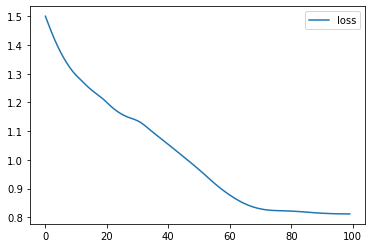

In [14]:
losses = pd.DataFrame(gpfa_hai.learner.losses.cpu().numpy(), columns=['loss'])

p = losses.plot()
plt.savefig(here('analysis/plots/loss_plot_hai_winter_4_var_200_obs_random_gaps_row_20_value_10.png'))
p

Lambda parameter, the latent variable is very similar to the 

In [15]:
gpfa_hai.data.corr()

,TA,SW_IN,LW_IN,VPD
TA,1.000000,-0.044290,0.493237,0.651335
SW_IN,-0.044290,1.000000,-0.262891,0.092488
LW_IN,0.493237,-0.262891,1.000000,0.033590
VPD,0.651335,0.092488,0.033590,1.000000


In [16]:
gpfa_hai.learner.model.covar_module.Lambda.detach()

tensor([[ 0.8637],
        [-0.0317],
        [ 0.4170],
        [ 0.5844]])

this is the value of the length scale of the RBF latent kernel

In [17]:
gpfa_hai.learner.model.covar_module.latent_kernel.lengthscale.detach()

tensor([[8.0826]])

In [18]:
gpfa_hai.learner.model.covar_module.psi.detach()

tensor([0.0015, 0.9846, 0.7611, 0.5384])

### Summer

The low correlation between `SW_IN` and `TA` is likely due to cloud cover, which is hard to predict with a dialy cycle. Hence we are looking at summer days and there is a much better correlation

In [19]:
hai_raw2 = pd.read_csv(here("data") / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1], nrows= 7 * 30 * 24 * 2)

In [20]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    #"PA": "PA"
}

units = {
    'TA': '°C',
    'SW_IN': 'W m-2',
    'LW_IN': 'W m-2',
    'VPD': 'hPa'
}

hai2 = (hai_raw2
       .rename(columns=meteo_vars)
       .set_index("TIMESTAMP_END")
       .loc[:, meteo_vars.values()])
hai2

,TA,SW_IN,LW_IN,VPD
TIMESTAMP_END,,,,
2000-01-01 00:30:00,-0.60,0.0,302.475,0.222
2000-01-01 01:00:00,-0.65,0.0,302.475,0.122
2000-01-01 01:30:00,-0.58,0.0,301.677,0.090
2000-01-01 02:00:00,-0.51,0.0,301.677,0.110
2000-01-01 02:30:00,-0.49,0.0,301.677,0.102
...,...,...,...,...
2000-07-28 22:00:00,12.69,0.0,344.126,1.453
2000-07-28 22:30:00,12.49,0.0,355.901,1.077
2000-07-28 23:00:00,12.41,0.0,355.901,0.927


<AxesSubplot: xlabel='TIMESTAMP_END'>

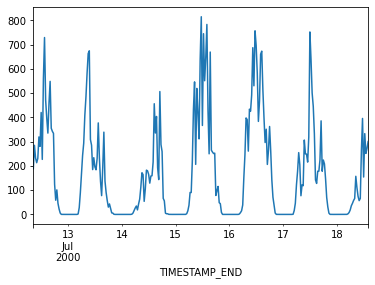

In [21]:
hai2[-800:-500].SW_IN.plot()

In [22]:
hai2[-800:-500].corr()

,TA,SW_IN,LW_IN,VPD
TA,1.000000,0.464253,0.555916,0.795267
SW_IN,0.464253,1.000000,0.106405,0.566460
LW_IN,0.555916,0.106405,1.000000,0.106487
VPD,0.795267,0.566460,0.106487,1.000000


In [23]:
gpdata2 = GPFADataTest(hai2[-800:-500].copy()).add_random_missing()

In [24]:
gp_imp2 = GPFAImputation(gpdata2.data, gpdata2.tidy_df(complete=True, is_missing=True))

In [25]:
%time data_imp2 = gp_imp2.impute()

CPU times: user 52min 5s, sys: 2.83 s, total: 52min 8s
Wall time: 11min 6s


In [26]:
gp_imp2.plot_pred(units=units)

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [27]:
data_imp2

,time,variable,mean,std
0,0.0,TA,9.370000,NaN
1,2.0,TA,9.810000,NaN
2,3.0,TA,10.060000,NaN
3,5.0,TA,10.420000,NaN
4,6.0,TA,10.760000,NaN
...,...,...,...,...
515,285.0,VPD,1.506036,1.083356
516,288.0,VPD,1.634738,1.082250
517,290.0,VPD,0.901000,0.000000
518,296.0,VPD,2.188000,0.000000


In [28]:
gp_imp2.rmse()

,variable,rmse
0,LW_IN,13.735727
1,SW_IN,200.357517
2,TA,0.329860
3,VPD,1.203304


In [29]:
gpdata2.data.corr()

,TA,SW_IN,LW_IN,VPD
TA,1.000000,0.478043,0.548133,0.803445
SW_IN,0.478043,1.000000,0.131970,0.627050
LW_IN,0.548133,0.131970,1.000000,0.075169
VPD,0.803445,0.627050,0.075169,1.000000


In [30]:
gp_imp2.learner.model.covar_module.Lambda.detach()

tensor([[0.9229],
        [0.4419],
        [0.4896],
        [0.7367]])

In [31]:
gp_imp2.learner.model.covar_module.psi.detach()

tensor([0.0049, 0.7676, 0.6991, 0.3637])

this is the value of the length scale of the RBF latent kernel

In [32]:
gp_imp2.learner.model.covar_module.latent_kernel.lengthscale.detach()

tensor([[6.5357]])

#### Only TA and SW_IN

In [33]:
gpdata3 = GPFADataTest(hai2[-800:-500].loc[:, ["TA", "SW_IN"]].copy()).add_random_missing()

In [34]:
gp_imp3 = GPFAImputation(gpdata3.data, gpdata3.tidy_df(complete=True, is_missing=True))

In [35]:
%time data_imp3 = gp_imp3.impute()

CPU times: user 1h 7min 37s, sys: 6.17 s, total: 1h 7min 43s
Wall time: 15min 19s


In [36]:
gp_imp3.plot_pred(units=units, bind_interaction=False)

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [37]:
data_imp3

,time,variable,mean,std
0,0.0,TA,9.370000,NaN
1,1.0,TA,9.770000,NaN
2,2.0,TA,9.810000,NaN
3,3.0,TA,10.060000,NaN
4,4.0,TA,10.220000,NaN
...,...,...,...,...
197,281.0,SW_IN,2.419998,0.000000
198,285.0,SW_IN,127.631271,172.353897
199,287.0,SW_IN,131.218018,172.359543
200,290.0,SW_IN,74.760002,0.000000


In [38]:
gpdata3.data.corr()

,TA,SW_IN
TA,1.000000,0.435817
SW_IN,0.435817,1.000000


In [39]:
gp_imp3.learner.model.covar_module.Lambda.detach()

tensor([[0.8706],
        [0.3693]])

this is the value of the length scale of the RBF latent kernel

In [40]:
gp_imp3.learner.model.covar_module.latent_kernel.lengthscale.detach()

tensor([[6.2930]])

In [41]:
gp_imp3.learner.model.covar_module.latent_kernel.lengthscale.detach()

tensor([[6.2930]])

## Continous gaps

Trying to see how the model works with a continous gap of 10% the length of the dataset for all variables

In [66]:
gpd_gap = GPFADataTest(hai).add_gap(20, variables = ['TA', 'SW_IN', 'LW_IN', 'VPD'])

In [67]:
gp_gap = GPFAImputation(gpd_gap.data, gpd_gap.tidy_df(complete=True, is_missing=True))

In [68]:
gp_gap

GPFA Imputation:
    N obs: 200
    N features 4 (TA, SW_IN, LW_IN, VPD)
    N missing observations 80

In [69]:
%time gp_gap.impute()

CPU times: user 49min 15s, sys: 2.51 s, total: 49min 18s
Wall time: 11min 4s


,time,variable,mean,std
0,0.0,TA,-0.600000,NaN
1,1.0,TA,-0.650000,NaN
2,2.0,TA,-0.580000,NaN
3,3.0,TA,-0.510000,NaN
4,4.0,TA,-0.490000,NaN
...,...,...,...,...
75,34.0,VPD,0.337558,0.258495
76,35.0,VPD,0.332052,0.255038
77,36.0,VPD,0.329296,0.252490
78,37.0,VPD,0.331272,0.250877


In [71]:
gap_plot= gp_gap.plot_pred(units=units, properties =  {'height': 190 , 'width': 380})

gap_plot.save(here("analysis/plots") /" plot_hai_winter_4_var_200_obs_gap_20.vl.json")
gap_plot

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [47]:
print(gp_gap.rmse().to_markdown(index=False))

| variable   |      rmse |
|:-----------|----------:|
| LW_IN      | 23.4842   |
| SW_IN      | 13.0957   |
| TA         |  0.425344 |
| VPD        |  0.224059 |


In [48]:
print(pd.DataFrame(gp_gap.learner.model.covar_module.Lambda.detach().numpy()).to_markdown(index=False))

|          0 |
|-----------:|
|  0.860184  |
| -0.0102606 |
|  0.501786  |
|  0.570728  |


In [49]:
psi = pd.DataFrame(gp_gap.learner.model.covar_module.psi.detach().numpy())
psi.insert(0, "variable", meteo_vars.values())
print(psi.to_markdown(index=False))

| variable   |          0 |
|:-----------|-----------:|
| TA         | 0.00122644 |
| SW_IN      | 0.985218   |
| LW_IN      | 0.654398   |
| VPD        | 0.555127   |


In [50]:
gp_gap.learner.model.covar_module.latent_kernel.lengthscale.detach()

tensor([[7.9630]])

<AxesSubplot: >

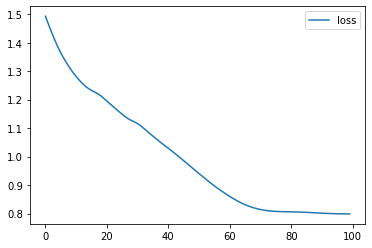

In [51]:
losses = pd.DataFrame(gp_gap.learner.losses.cpu().numpy(), columns=['loss'])

p = losses.plot()
plt.savefig(here('analysis/plots/') /'loss_plot_hai_winter_4_var_200_obs_gap_20.png')
p